In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from classifier import *
import features as fe 
import utils as ut

In [64]:
X_train_face_img, X_train_nonface_img, X_test_img, y_train_face, y_train_nonface, y_test = ut.get_test_train_data()

### Testing AdaBoost

In [65]:
X_train_img = np.concatenate((X_train_face_img, X_train_nonface_img))
y_train = np.concatenate((y_train_face, y_train_nonface))
X_train_ada, y_train_ada = ut.random_subset(X_train_img, y_train, 100)
X_test_ada, y_test_ada = ut.random_subset(X_test_img, y_test, 100)

In [66]:
rect = fe.get_rectanges(19, 19)
no_rect = fe.get_no_rectangles(19, 19)
X_train_ada_fe = fe.feature_extraction_images(X_train_ada, rect, no_rect)
X_test_ada_fe = fe.feature_extraction_images(X_test_ada, rect, no_rect)

In [67]:
a = AdaBoostClassifier()
a.fit(X_train_ada_fe, y_train_ada, 2)

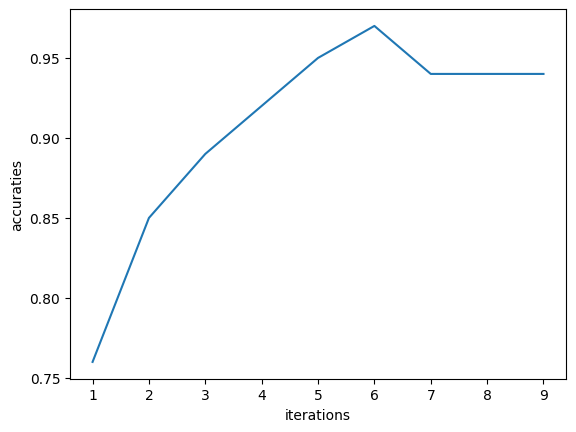

In [68]:
iters = list(range(1, 10))
accuracies = []
a = AdaBoostClassifier()
for iter in iters:
    a.fit(X_train_ada_fe, y_train_ada, iter)
    accuracy = a.score(X_test_ada_fe, y_test_ada)
    accuracies.append(accuracy)

plt.xlabel("iterations")
plt.ylabel("accuraties")
plt.plot(iters, accuracies)
plt.show()

In [86]:
print(a.threshold*0.98)
print(a.false_positive_rate(X_test_ada_fe, y_test_ada))
print(a.detection_rate(X_test_ada_fe, y_test_ada))

1.2e-322
0.23469387755102042
0.01


In [69]:
# split the training data into 10 folds
X_train_folds = np.array_split(X_train_ada_fe, 10)
y_train_folds = np.array_split(y_train_ada, 10)


In [101]:
f = 0.9
d = 0.9
F_target = 0.001
Threshold_retention = 0.99
Strong_Classifiers = []


# function for average false positive rate and detection rate for 3 random folds
def get_avg_fpr_dtr(a,X_train_folds, y_train_folds,number):
    false_positive_rate = 0
    detection_rate = 0
    for i in range(number):
        index = np.random.choice(10,1, replace=False)
        X_train = X_train_folds[index[0]]
        y_train = y_train_folds[index[0]]
        false_positive_rate += a.false_positive_rate(X_train, y_train)
        detection_rate += a.detection_rate(X_train, y_train)
    return false_positive_rate/3, detection_rate/3
F = [0.6]
D = [0.6]
F_new = F[-1]
while F_new > F_target:
    a = AdaBoostClassifier()
    F_new = F[-1]
    no_of_features = 0
    while F_new > f*F[-1]:
        no_of_features += 1
        a.fit(X_train_ada_fe, y_train_ada, no_of_features)         
        fpr, dtr = get_avg_fpr_dtr(a,X_train_folds, y_train_folds,3)
        F_new = fpr
        D_new = dtr
        # decrease the threshold for the ith strong classifier in the cascade
        print("passed the first while loop")
        while(True):            
            a.set_threshold(a.threshold*Threshold_retention)
            fpr, dtr = get_avg_fpr_dtr(a,X_train_folds, y_train_folds,3)
            F_new = fpr
            D_new = dtr
            print("in the second while loop and the threshold is", a.threshold," ", F_new, " ", D_new," ",d*D[-1]," ",no_of_features)
            if D_new > d*D[-1]:          
                break      
    print(F_new)          
    F.append(F_new)
    D.append(D_new)
    Strong_Classifiers.append(a)     


Strong_Classifiers = np.array(Strong_Classifiers)
print("the length of the strong classifiers is", len(Strong_Classifiers))




passed the first while loop
in the second while loop and the threshold is 1.1813596083663576   0.24722222222222223   0.3333333333333333   0.54   1
in the second while loop and the threshold is 1.169546012282694   0.1726190476190476   0.39999999999999997   0.54   1
in the second while loop and the threshold is 1.157850552159867   0.10317460317460318   0.26666666666666666   0.54   1
in the second while loop and the threshold is 1.1462720466382683   0.13333333333333333   0.5666666666666667   0.54   1
0.13333333333333333
passed the first while loop
in the second while loop and the threshold is 1.1813596083663576   0.05555555555555555   0.39999999999999997   0.51   1
in the second while loop and the threshold is 1.169546012282694   0.15079365079365079   0.3   0.51   1
in the second while loop and the threshold is 1.157850552159867   0.1619047619047619   0.3666666666666667   0.51   1
in the second while loop and the threshold is 1.1462720466382683   0.10317460317460318   0.4666666666666666  

In [ ]:
print(np.random.choice(10, 1, replace=False))